In [2]:
#libraries
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
#constants
nsamp = 50
dim = 2
s= 0.5

In [8]:
#generate data
c0mean = np.ones(dim)
c0cov = 0.5 * np.eye(dim)

c0_samples = np.random.multivariate_normal(c0mean, c0cov, nsamp)
c0_y = np.zeros(nsamp)

c1mean = -1 * np.ones(dim)
c1cov = 0.2 * np.eye(dim)

c1_samples = np.random.multivariate_normal(c1mean, c1cov, nsamp)
c1_y = np.ones(nsamp)

In [9]:
#define objective function, stack data for computation
X = np.column_stack((np.ones(nsamp*2), np.vstack([c0_samples, c1_samples])))
y = np.hstack([c0_y, c1_y])
def crossentropy_loss(w):
    loss = y.T @ np.log(1 + np.exp(-w @ X.T)) + (1 - y).T @ np.log(1 + np.exp(w @ X.T))
    return loss

In [10]:
#minimize cross entropy loss 
res = minimize(crossentropy_loss, [0,0,0], method='BFGS', options={'disp': True})
w = res.x

         Current function value: nan
         Iterations: 28
         Function evaluations: 560
         Gradient evaluations: 140


/var/folders/6_/478gy13932n5hyzwyl7crpwm0000gn/T/ipykernel_570/495419626.py:5: RuntimeWarning: overflow encountered in exp
  loss = y.T @ np.log(1 + np.exp(-w @ X.T)) + (1 - y).T @ np.log(1 + np.exp(w @ X.T))
/var/folders/6_/478gy13932n5hyzwyl7crpwm0000gn/T/ipykernel_570/495419626.py:5: RuntimeWarning: invalid value encountered in matmul
  loss = y.T @ np.log(1 + np.exp(-w @ X.T)) + (1 - y).T @ np.log(1 + np.exp(w @ X.T))
/var/folders/6_/478gy13932n5hyzwyl7crpwm0000gn/T/ipykernel_570/495419626.py:5: RuntimeWarning: overflow encountered in exp
  loss = y.T @ np.log(1 + np.exp(-w @ X.T)) + (1 - y).T @ np.log(1 + np.exp(w @ X.T))
/var/folders/6_/478gy13932n5hyzwyl7crpwm0000gn/T/ipykernel_570/495419626.py:5: RuntimeWarning: invalid value encountered in matmul
  loss = y.T @ np.log(1 + np.exp(-w @ X.T)) + (1 - y).T @ np.log(1 + np.exp(w @ X.T))
/var/folders/6_/478gy13932n5hyzwyl7crpwm0000gn/T/ipykernel_570/495419626.py:5: RuntimeWarning: overflow encountered in exp
  loss = y.T @ np.log(1 +

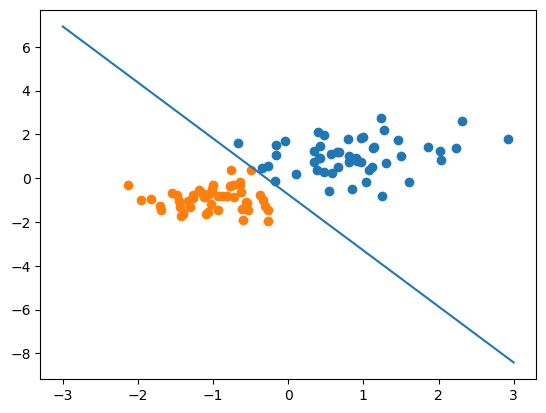

In [11]:
#plot stuff
plt.scatter(c0_samples[:,0], c0_samples[:,1])
plt.scatter(c1_samples[:,0], c1_samples[:,1])
xvalues = np.linspace(-3,3,100)
plt.plot(xvalues, -(w[0] + w[1] * xvalues) / w[2])

In [12]:
#gbf function
def gbf(x, mean, s, axis):
    value = np.exp(-(1 / 2 * s**2) * np.sum((x - mean)**2, axis))
    return value

In [13]:
#define objective function, stack data for computation
m = np.vstack([c0_samples, c1_samples])
Xg = np.column_stack((np.ones(nsamp*2), gbf(m,[-1,1],s,1), gbf(m, [0,0],s,1), gbf(m, [1,-1],s,1)))
yg = np.hstack([c0_y, c1_y])
def crossentropy_loss_gaussian(wg):
    NLL = yg.T @ np.log(1 + np.exp(-wg @ Xg.T)) + (1 - yg).T @ np.log(1 + np.exp(wg @ Xg.T))
    return NLL

In [20]:
#minimize cross-entropy loss with gaussian basis 
res_g = minimize(crossentropy_loss_gaussian, np.zeros(4), method='BFGS', options={'disp': True})
wg = res_g.x

Optimization terminated successfully.
         Current function value: 66.108217
         Iterations: 18
         Function evaluations: 105
         Gradient evaluations: 21


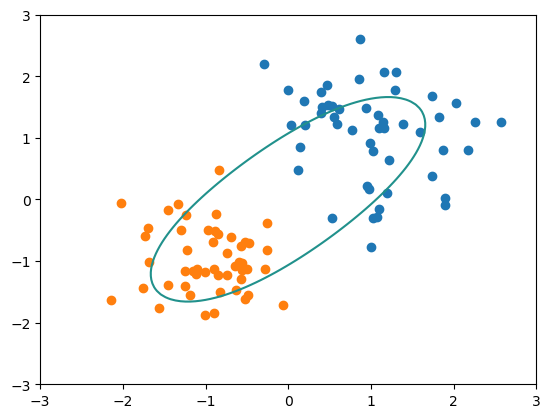

In [74]:
#plot stuff
plt.scatter(c0_samples[:,0], c0_samples[:,1])
plt.scatter(c1_samples[:,0], c1_samples[:,1])
xvalues = np.linspace(-3,3,100)
x1,x2 = np.meshgrid(xvalues, xvalues)
xmesh = np.stack((x1,x2)).T
Z = wg[0] + wg[1]*gbf(xmesh,[-1,1],s,2) + wg[2]*gbf(xmesh, [0,0],s,2) + wg[3]*gbf(xmesh, [1,-1],s,2)
plt.contour(x1,x2,Z,0)
#plt.plot(xvalues, -(w[0] + w[1] * xvalues) / w[2])

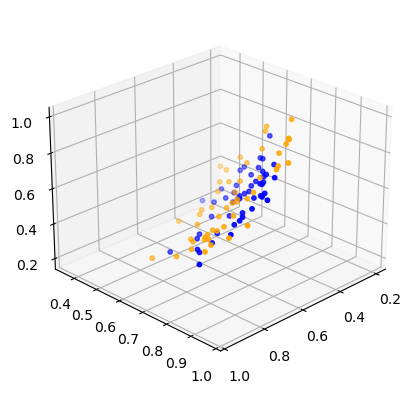

In [83]:
#graph data points after gaussian basis transformation
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(gbf(c0_samples,[-1,1],s,1),gbf(c0_samples,[0,0],s,1),gbf(c0_samples,[1,-1],s,1), s=10, color="orange")
ax.scatter(gbf(c1_samples,[-1,1],s,1),gbf(c1_samples,[0,0],s,1),gbf(c1_samples,[1,-1],s,1), s=10, color="blue")
ax.view_init(25, 45)

In [76]:
#define objective function, stack data for computation
m = np.vstack([c0_samples, c1_samples])
Xg2 = np.column_stack((np.ones(nsamp*2), gbf(m,[-1,-1],s,1), gbf(m, [1,1],s,1)))
yg2 = np.hstack([c0_y, c1_y])
def loss_gaussian2(wg2):
    NLL = yg2.T @ np.log(1 + np.exp(-wg2 @ Xg2.T)) + (1 - yg2).T @ np.log(1 + np.exp(wg2 @ Xg2.T))
    return NLL

In [84]:
#minimize cross-entropy loss with new gaussian basis functions 
res_g2 = minimize(loss_gaussian2, np.zeros(3), method='BFGS', options={'disp': True})
wg2 = res_g2.x

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 29
         Function evaluations: 124
         Gradient evaluations: 31


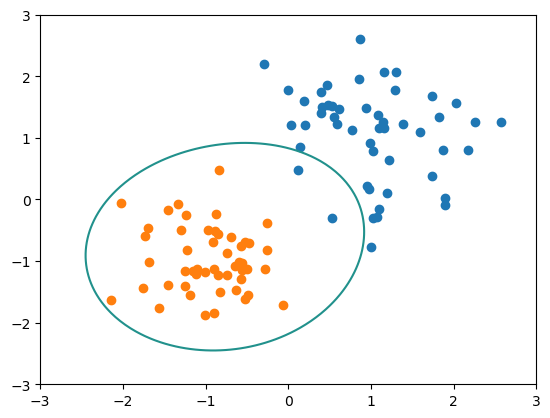

In [78]:
#plot stuff
plt.scatter(c0_samples[:,0], c0_samples[:,1])
plt.scatter(c1_samples[:,0], c1_samples[:,1])
xvalues = np.linspace(-3,3,100)
x1,x2 = np.meshgrid(xvalues, xvalues)
xmesh = np.stack((x1,x2)).T
Z = wg2[0] + wg2[1]*gbf(xmesh,[-1,-1],s,2) + wg[2]*gbf(xmesh, [1,1],s,2)
plt.contour(x1,x2,Z,0)
#plt.plot(xvalues, -(w[0] + w[1] * xvalues) / w[2])

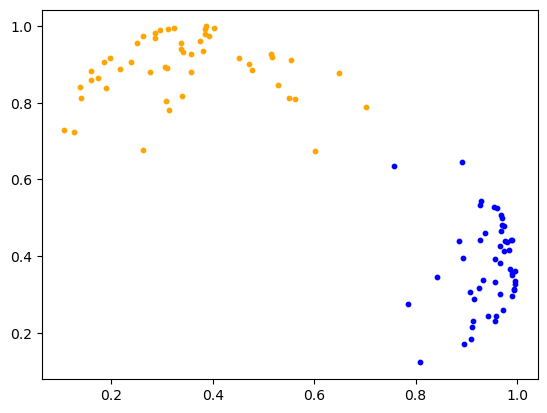

In [88]:
#graph data points after new gaussian basis transformation
plt.scatter(gbf(c0_samples,[-1,-1],s,1),gbf(c0_samples,[1,1],s,1), s=10, color="orange")
plt.scatter(gbf(c1_samples,[-1,-1],s,1),gbf(c1_samples,[1,1],s,1), s=10, color="blue")